# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## GeoTIFF file post-processing: Spatial operations

22/09/2020

**M. Iturbide** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

This notebook illustrates a few steps to obtain a given spatial subset from a GeoTIFF file downloaded from the Interactive Atlas using `climate4R` and `rgdal`.

### Load libraries

In [ ]:
library(transformeR)
library(loadeR)
library(loadeR.2nc)
library(geoprocessoR)
library(visualizeR)
library(RColorBrewer)
library(sp)
library(rgdal)

### Load GeoTIFF data

GeoTIFF is a public domain standard to embed georeferencing information into TIFF image files. This image format is provided by the Interactive Atlas and it can be read with the `rgdal` library. Here, we use the CMIP5 Mean temperature Change (deg C) for RCP 8.5. To obtain the file loaded here, or any other, select the Download as GeoTIFF option in the Interactive Atlas.
![GeoTIFF access](auxiliary-material/geotiff-access-ia.png)

In [2]:
map <- readGDAL("auxiliary-material/CMIP5 - Mean temperature (T) Change deg C - Long Term (2081-2100) RCP 8.5 1986-2005 - Annual (mean of 29 models).tiff")

auxiliary-material/CMIP5 - Mean temperature (T) Change deg C - Long Term (2081-2100) RCP 8.5 1986-2005 - Annual (mean of 29 models).tiff has GDAL driver GTiff 
and has 90 rows and 180 columns


In order to continue with climate4R, first, we need to convert `map` to a `climate4R` grid object.

In [ ]:
delta <- sgdf2clim(map)

### Basic display examples

We can now use standard climate4R functions, such as `spatialPlot` to creat map figures.

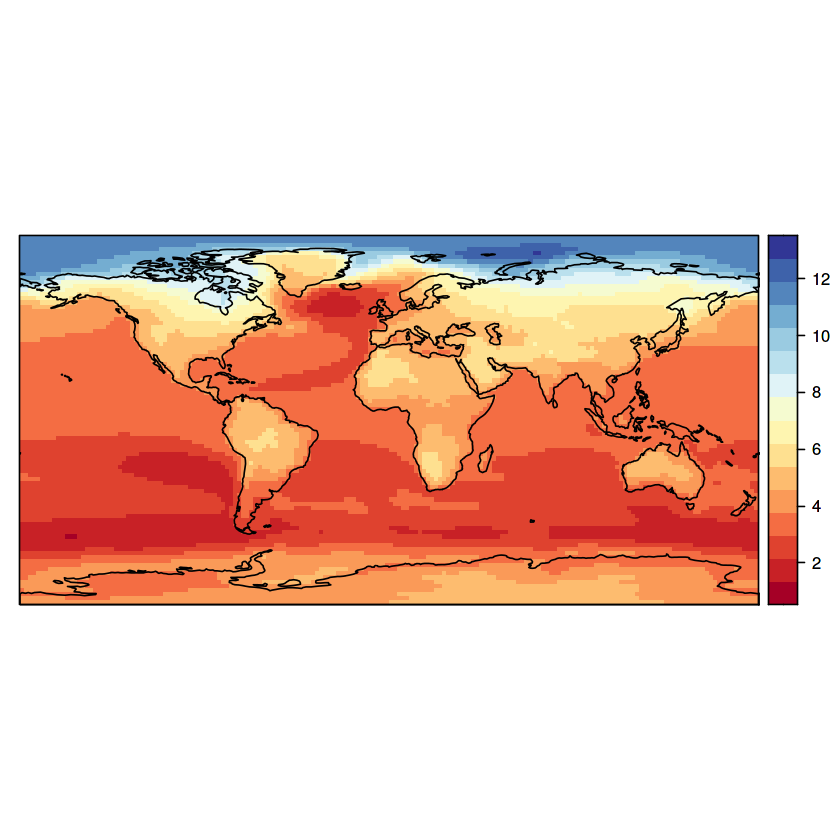

In [4]:
spatialPlot(delta, backdrop.theme = "coastline")

#### Mask land

We can now combine this information with other available in the repository. For instance, the masking surface for this example is provided as a NetCDF in the [reference-grids](../reference-grids/README.md) folder. Therefore, we can load the corresponding mask (2 degrees for this CMIP5 example), and use it to select land-only data.

In [ ]:
mask <- loadGridData("../reference-grids/land_sea_mask_2degree.nc4", var = "sftlf")
mask.land <- binaryGrid(mask, condition = "GT", threshold = 0.999, values = c(NA, 1))

Here, we apply the mask using `gridArithmetic` (i.e. perfom `delta` x `mask`) and display it. We also reverse the default color scheme to have hot colors for larger warming.

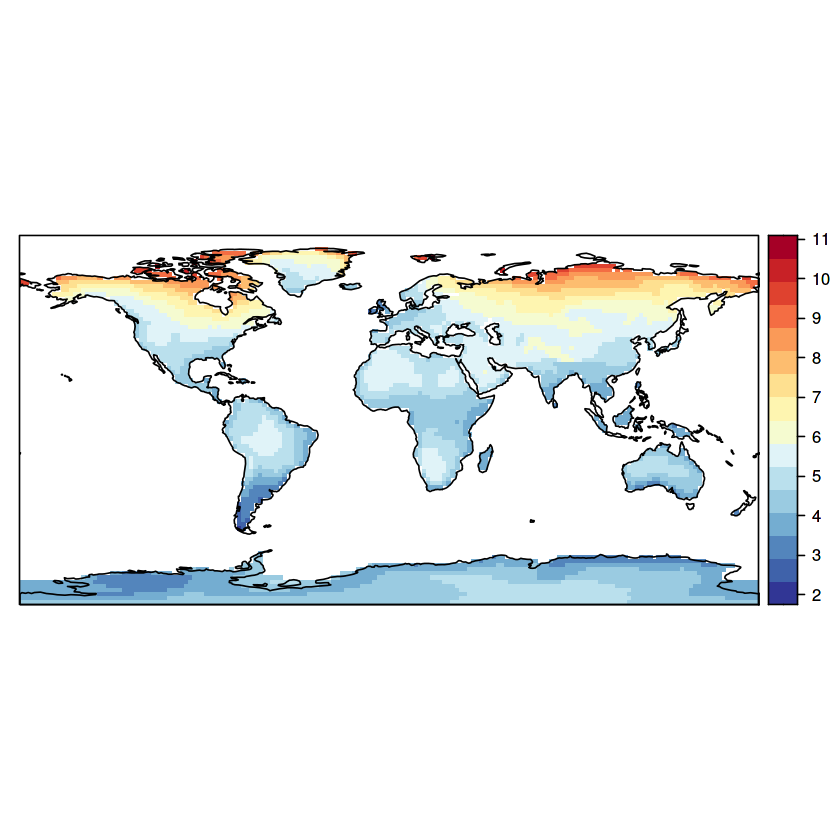

In [6]:
delta.masked <- gridArithmetics(delta, mask.land, operator = "*")
spatialPlot(delta.masked, backdrop.theme = "coastline", rev.colors = TRUE)

#### Spatial subsetting

We can get a spatial subset with `subsetGrid`. E.g. for Europe.

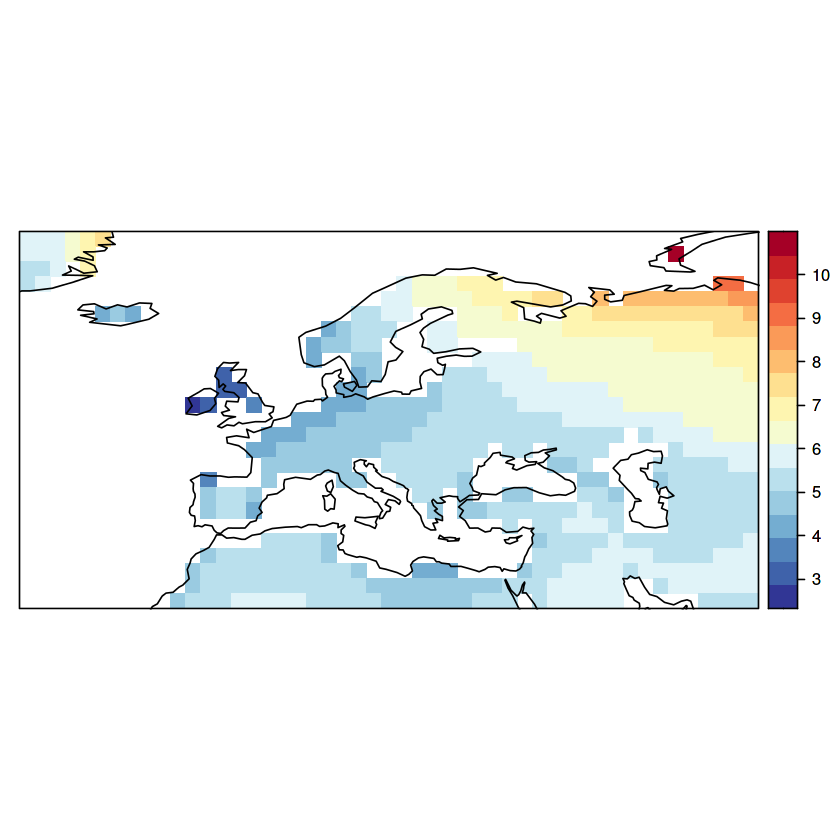

In [7]:
delta.EU <- subsetGrid(delta.masked, lonLim = c(-30, 65), latLim = c(28, 75))
spatialPlot(delta.EU, backdrop.theme = "coastline", rev.colors = TRUE)

Or using the IPCC WGI [reference regions](../reference-regions/README.md).

In [ ]:
regions <- get(load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda"))
regions <- as(regions, "SpatialPolygons")
proj4string(regions) <- CRS("+init=epsg:4326")

Define the original projection of the data (in this case is the same as the regions)

In [ ]:
delta.masked <- projectGrid(delta.masked, proj4string(regions))

Select the desired regions by acronym. Display the names typing `names(regions)`. Here we select the European regions:

In [10]:
regionnames <- c("NEU", "WCE", "EEU", "MED")

Get a Spatial subset by intersection with a polygons object

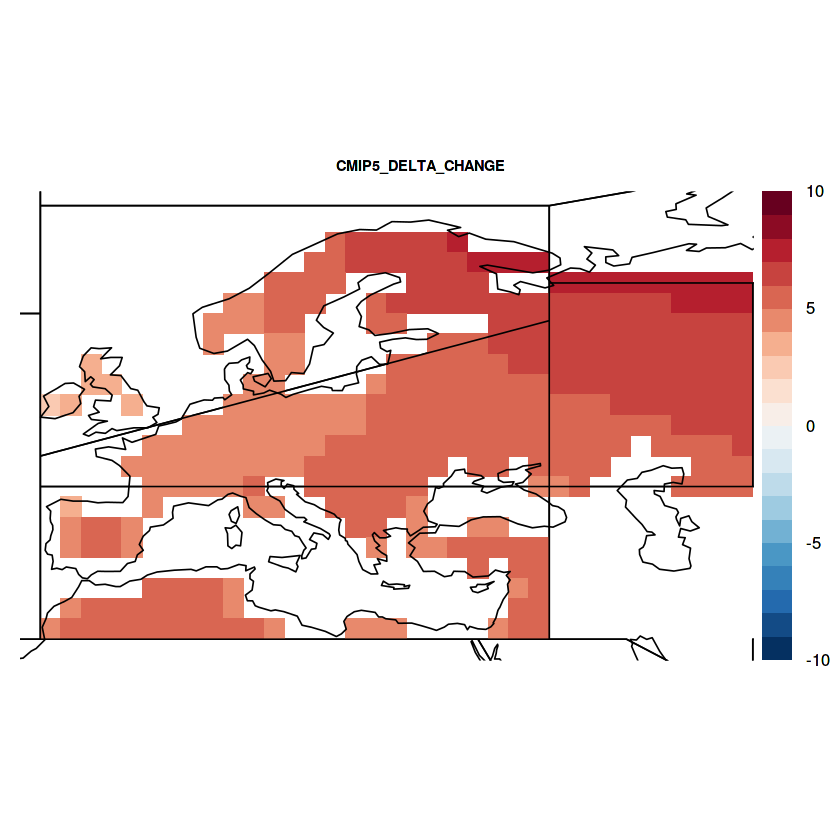

In [11]:
# Overly with reference regions
delta.masked.regs <- overGrid(delta.masked, regions[regionnames], subset = TRUE)

spatialPlot(delta.masked.regs,
            color.theme = "RdBu", 
            rev.colors = TRUE,
            strip = FALSE,
            as.table = TRUE,
            backdrop.theme = "coastline",
            sp.layout = list(list(regions, first = FALSE)),
            par.settings = list(axis.line = list(col = "transparent")),
            main =  list("CMIP5_DELTA_CHANGE",
                         cex = 0.7),
            at = seq(-10, 10, 1),
            set.max = 10,
            set.min = -10)

#### Regional averages

Calculate regional averages for each region using `aggregateGrid`

In [ ]:
reg.averages <- sapply(regionnames, function(i){
      reg <- overGrid(delta.masked, regions[i])
      grid <- aggregateGrid(reg, aggr.spatial = list(FUN = "mean", na.rm = TRUE), weight.by.lat = TRUE)
      grid$Data
})

In [16]:
reg.averages

NEU      WCE      EEU      MED 
5.509449 5.107509 6.195886 5.063910

### Session info

In [14]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/libblas/libblas.so.3.0
LAPACK: /usr/lib/lapack/liblapack.so.3.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-12        sp_1.4-5            RColorBrewer_1.1-2 
 [4] visualizeR_1.6.1    geoprocessoR_0.2.0  transformeR_2.1.2  
 [7] loadeR.2nc_0.1.1    loadeR_1.7.1        climate4R.UDG_0.2.3
[10] loadeR.java_1.1.1   rJava_1.0-4        

loaded via a namespace (an